#Ananyae

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.stats import multivariate_normal
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd=tfp.distributions

In [ ]:
pr=[.2,.3,.5]
u=[[2.0,1.0],[1.0,-1.0],[1.0,1.0]]
var=[ [[1.0,0.0],[0.0,1.0]], [[2.0,0.0],[0.0,2.0]] ,[[1.5,0.0],[0.0,1.0]]]
sd=[[1.0,1.0],[1.414,1.414],[1.5**.5,1]]
base_dist = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros([2])) 
mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pr),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=u,
        scale_diag=sd)
)

In [ ]:
def T_(u,c,w,b):
  def _tem(t,w,c,b):
    return t+c*tf.tanh(tf.tensordot(t,w,1)+b)
  return tf.map_fn(lambda t:_tem(t,w,c,b),elems=u) 

In [ ]:
def detjt(w,c,b,u_):
  def temp_(w,c,b,u):
    return tf.constant([1.0])+tf.divide(tf.tensordot(w,c,1),tf.square(tf.cosh(tf.tensordot(w,u,1)+b)))
  return tf.math.log(tf.map_fn(lambda t:temp_(w,c,b,t),elems=u_))


In [ ]:
def loss(c,w,b,n):
  val=0;
  us=base_dist.sample(n)
  d=mvgmm.log_prob(T_(us,c,w,b))
  p_b=base_dist.log_prob(us)
  det=detjt(w,c,b,us)
  val=tf.reduce_mean(p_b-det-d)
  return val

In [ ]:
def T(u,c,w,b):
  return tf.cast(u+tf.multiply(c,tf.tanh(tf.tensordot(u,w,1)+b)),tf.float32)
  

In [ ]:
def cal_pdf(u,x,sigma):
  a=tf.cast(x-u,tf.float32)
  ma=tf.cast(tf.linalg.inv(sigma),tf.float32)
  maa=tf.cast(tf.linalg.matmul(a,ma),tf.float32)
  y=tf.multiply(tf.constant([-.5]),tf.cast(tf.linalg.matmul(maa,tf.transpose(a)),tf.float32))
  return tf.divide(tf.exp(y),tf.sqrt(tf.linalg.det(tf.multiply(2*np.pi,sigma))))

In [ ]:
def p_gmm(u_,c,w,b):
  x=T(u_,c,w,b)
  return tf.multiply(tf.constant([pr[0]]),cal_pdf(tf.constant([u[0]]),x,tf.constant(var[0])))+tf.multiply(tf.constant([pr[1]]),cal_pdf(tf.constant([u[1]]),x,tf.constant(var[1])))+tf.multiply(tf.constant([pr[2]]),cal_pdf(tf.constant([u[2]]),x,tf.constant(var[2])))

In [ ]:
c = tf.Variable([np.random.random(),np.random.random()], trainable=True)
b = tf.Variable(np.random.random(), trainable=True)
w = tf.Variable([np.random.random(),np.random.random()], trainable=True)

In [ ]:
def step():
    with tf.GradientTape(persistent=True) as tape:
        # Calculate loss
        poly_loss = loss(c,w,b,20)
    # Calculate gradients
    c_gradients, w_gradients, b_gradients = tape.gradient(poly_loss, [c, w, b])

    # Update variables
    # a = a - a_gradients * 0.001  # Gives error
    c.assign(c-c_gradients * 0.001)
    w.assign_sub(w_gradients * 0.001)
    b.assign_sub(b_gradients * 0.001)

In [ ]:
# Training loop
for _ in range(10000):
    step()

In [ ]:
print(c.numpy(),b.numpy(),w.numpy())

[1.5551172  0.82287836] 1.1600201 [0.3133504  0.37186405]


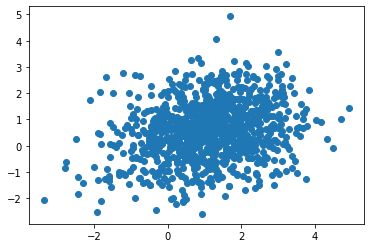

In [ ]:
sam=base_dist.sample(1000)
data=T_(sam,c,w,b)
plt.scatter(data[:,0],data[:,1])